## Reinforcement learning

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# === Path and ticker mapping ===
predicted_data_folder = r"Pred_Data"

ticker_to_basename = {
    "^NSEI": "NIFTY_50",
    "^NSEBANK": "NIFTY_BANK",
    "^CNXIT": "NIFTY_IT",
    "^CNXPHARMA": "NIFTY_PHARMA",
    "^CNXFMCG": "NIFTY_FMCG",
    "^CNXAUTO": "NIFTY_AUTO",
    "^CNXMETAL": "NIFTY_METAL",
    "^CNXREALTY": "NIFTY_REALTY",
    "^CNXENERGY": "NIFTY_ENERGY",
    "NIFTY_FIN_SERVICE.NS": "NIFTY_FIN_SERVICE",
    "RELIANCE.NS": "RELIANCE_INDUSTRIES_LTD",
    "TCS.NS": "TATA_CONSULTANCY_SERV_LT",
    "SUNPHARMA.NS": "SUN_PHARMACEUTICAL_IND_L",
    "ICICIBANK.NS": "ICICI_BANK_LTD.",
    "INFY.NS": "INFOSYS_LIMITED",
    "SBIN.NS": "STATE_BANK_OF_INDIA",
    "BHARTIARTL.NS": "BHARTI_AIRTEL_LIMITED",
    "ITC.NS": "ITC_LTD",
    "LT.NS": "LARSEN_&_TOUBRO_LTD.",
    "HINDUNILVR.NS": "HINDUSTAN_UNILEVER_LTD."
}

In [3]:
def simulate_investment(df, amt, start_date, end_date, plot=False):
    df = df.copy()

    if 'Datetime' in df.index.names:
        df = df.reset_index()

    if 'Datetime' not in df.columns:
        raise ValueError("No 'Datetime' column found after reset_index.")

    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").reset_index(drop=True)

    # ---- Filter to start/end range ----
    actual_start = df[df["Datetime"] >= pd.to_datetime(start_date)]
    if actual_start.empty:
        raise ValueError("No data after the given start_date")
    start_row = actual_start.iloc[0]

    actual_end = df[df["Datetime"] <= pd.to_datetime(end_date)]
    if actual_end.empty:
        raise ValueError("No data before the given end_date")
    end_row = actual_end.iloc[-1]

    df = df[(df["Datetime"] >= start_row["Datetime"]) & (df["Datetime"] <= end_row["Datetime"])].reset_index(drop=True)

    # ---- Compute predicted and actual returns ----
    df["pred_return"] = df["PredictedPrice"].pct_change()
    df["actual_return"] = df["ActualPrice"].pct_change()

    invested = False
    cash = amt
    values = [cash]  # track value over time

    for i in range(1, len(df)):
        signal = df.loc[i, "pred_return"]
        actual_r = df.loc[i, "actual_return"]

        # If model predicts profit
        if signal > 0:
            if not invested:
                invested = True
            cash *= (1 + actual_r)
        else:
            if invested:
                invested = False
        values.append(cash)

    df["InvestmentValue"] = values

    final_value = df["InvestmentValue"].iloc[-1]
    profit_pct = ((final_value - amt) / amt) * 100

    summary = {
        "Initial Date Given": start_date,
        "Actual date of investment": str(start_row["Datetime"].date()),
        "Final Date Given": end_date,
        "Actual date of withdraw": str(end_row["Datetime"].date()),
        "Initial Amount": amt,
        "Final Amount": round(final_value, 2),
        "Return (%)": round(profit_pct, 2)
    }

    return summary


In [4]:
import numpy as np
import pandas as pd

def optimize_rl_portfolio(window_df, lr=0.05, gamma=0.9, episodes=100):
    """
    Simple reinforcement-learning optimizer for portfolio weights.
    - window_df: recent returns (DataFrame of assets)
    - lr: learning rate
    - gamma: discount factor
    - episodes: number of learning iterations
    Returns: optimized weight vector
    """

    n_assets = window_df.shape[1]
    weights = np.ones(n_assets) / n_assets  # start equally weighted

    for ep in range(episodes):
        # --- State: last observed returns
        state = window_df.iloc[-1].values  

        # --- Reward: portfolio return = wᵀ * r
        reward = np.dot(weights, state)
        discounted_reward = gamma * reward

        # --- Gradient: move weights in direction of asset returns
        grad = state - np.dot(weights, state)
        weights += lr * grad * discounted_reward

        # --- Normalize to sum to 1
        weights = np.maximum(weights, 0)
        weights /= np.sum(weights)

    return weights

In [5]:
def rl_portfolio_simulation(predicted_data_folder, ticker_to_basename, 
                            apply_date, withdraw_date, k=3, lr=0.05, gamma=0.9, episodes=100):
    """
    Reinforcement Learning–based intraday portfolio simulation.
    Uses rolling k-day windows for state estimation.
    Returns total return, weights evolution, and average risk.
    """
    import os

    # --- Load data ---
    all_returns = {}
    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice"])
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df = df.iloc[300:].set_index("Datetime")

        mask = (df.index >= pd.to_datetime(apply_date) - pd.Timedelta(days=k)) & \
               (df.index <= pd.to_datetime(withdraw_date))
        df = df.loc[mask]
        if not df.empty:
            all_returns[basename] = df["Actual_Return"]

    if not all_returns:
        raise ValueError("No valid assets found in given period")

    actual_df = pd.concat(all_returns, axis=1).dropna()
    time_points = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) &
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()

    weights_history = pd.DataFrame(index=time_points, columns=list(all_returns.keys()), dtype=float)
    port_returns = []

    # --- Rolling simulation ---
    for current_time in time_points:
        window_start = current_time - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]
        if len(window_df) < 10:
            continue

        # Optimize weights using RL agent
        opt_weights = optimize_rl_portfolio(window_df, lr=lr, gamma=gamma, episodes=episodes)
        weights_history.loc[current_time, :] = opt_weights

        # Portfolio return for this step
        step_ret = np.dot(opt_weights, actual_df.loc[current_time].values)
        port_returns.append(step_ret)

    # --- Compute summary stats ---
    port_returns = np.array(port_returns)
    total_return = np.prod(1 + port_returns) - 1
    avg_volatility = np.std(port_returns)

    summary = {
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": k,
        "Total_Return": float(total_return),
        "Average_Risk": float(avg_volatility)
    }

    print("\n=== Reinforcement Learning Portfolio Simulation ===")
    print(f"Investment Period: {apply_date} → {withdraw_date}")
    print(f"Lookback Window: {k} days")
    print(f"Total Return: {total_return:.4%}")
    print(f"Average Risk (Volatility): {avg_volatility:.6f}")
    print(f"Total Time Steps: {len(port_returns)}")

    return summary, weights_history


In [6]:
summary_rl, weights_rl = rl_portfolio_simulation(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    apply_date="2025-10-01",
    withdraw_date="2025-10-20",
    k=30,        # rolling window
    lr=0.05,    # learning rate
    gamma=0.9,  # discount factor
    episodes=100
)



=== Reinforcement Learning Portfolio Simulation ===
Investment Period: 2025-10-01 → 2025-10-20
Lookback Window: 30 days
Total Return: 3.8432%
Average Risk (Volatility): 0.001660
Total Time Steps: 84


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rl_portfolio_simulation(predicted_data_folder, ticker_to_basename, 
                            apply_date, withdraw_date, k=3, lr=0.05, gamma=0.9, episodes=100):
    """
    Reinforcement Learning–based intraday portfolio simulation.
    Uses rolling k-day windows for state estimation and portfolio optimization.

    Returns:
      summary: dict with total return, avg risk, VaR values, etc.
      weights_history: DataFrame with weight evolution per timestamp
      return_df: DataFrame with Datetime and Realized Portfolio Value (₹100 base)
    """

    # -----------------------------
    # 1️⃣ Load Data
    # -----------------------------
    all_returns = {}
    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice"])
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df = df.iloc[300:].set_index("Datetime")

        mask = (df.index >= pd.to_datetime(apply_date) - pd.Timedelta(days=k)) & \
               (df.index <= pd.to_datetime(withdraw_date))
        df = df.loc[mask]
        if not df.empty:
            all_returns[basename] = df["Actual_Return"]

    if not all_returns:
        raise ValueError("No valid assets found in given period")

    actual_df = pd.concat(all_returns, axis=1).dropna()
    time_points = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) &
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()

    weights_history = pd.DataFrame(index=time_points, columns=list(all_returns.keys()), dtype=float)
    port_returns = []
    realized_times = []

    # -----------------------------
    # 2️⃣ Rolling Simulation
    # -----------------------------
    for current_time in time_points:
        window_start = current_time - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]

        if len(window_df) < 10:
            continue

        # Optimize weights using RL agent (user-provided function)
        opt_weights = optimize_rl_portfolio(window_df, lr=lr, gamma=gamma, episodes=episodes)
        weights_history.loc[current_time, :] = opt_weights

        # Portfolio return at this step
        step_ret = np.dot(opt_weights, actual_df.loc[current_time].values)
        port_returns.append(step_ret)
        realized_times.append(current_time)

    port_returns = np.array(port_returns)

    # -----------------------------
    # 3️⃣ Summary Metrics
    # -----------------------------
    total_return = np.prod(1 + port_returns) - 1
    avg_volatility = np.std(port_returns)

    # -----------------------------
    # 4️⃣ Compute VaR (Parametric & Historical)
    # -----------------------------
    confidence_level = 0.95
    z_score = 1.65  # 95% confidence

    if len(port_returns) > 0:
        mu_p = np.mean(port_returns)
        sigma_p = np.std(port_returns)
        var_parametric = -(mu_p - z_score * sigma_p)
        var_historical = -np.percentile(port_returns, (1 - confidence_level) * 100)
    else:
        var_parametric, var_historical = np.nan, np.nan

    # -----------------------------
    # 5️⃣ Realized Portfolio Value (₹100 base)
    # -----------------------------
    if len(port_returns) > 0:
        realized_series = pd.Series(port_returns, index=pd.DatetimeIndex(realized_times))
        realized_value = 100 * (1 + realized_series).cumprod()
        return_df = pd.DataFrame({
            "Datetime": realized_value.index,
            "Realized_Portfolio_Value": realized_value.values
        }).reset_index(drop=True)
    else:
        return_df = pd.DataFrame({
            "Datetime": [],
            "Realized_Portfolio_Value": []
        })

    # -----------------------------
    # 6️⃣ Summary Dictionary
    # -----------------------------
    summary = {
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": k,
        "Learning_Rate": lr,
        "Gamma": gamma,
        "Episodes": episodes,
        "Total_Return": float(total_return),
        "Average_Risk": float(avg_volatility),
        "Parametric_VaR": float(var_parametric) if not np.isnan(var_parametric) else None,
        "Historical_VaR": float(var_historical) if not np.isnan(var_historical) else None,
        "Confidence_Level": confidence_level
    }

    # -----------------------------
    # 7️⃣ Console Output
    # -----------------------------
    print("\n=== Reinforcement Learning Portfolio Simulation ===")
    print(f"Investment Period: {apply_date} → {withdraw_date}")
    print(f"Lookback Window: {k} days | LR={lr}, Gamma={gamma}, Episodes={episodes}")
    print(f"Total Return (Realized): {total_return:.4%}")
    print(f"Average Risk (Volatility): {avg_volatility:.6f}")
    if not np.isnan(var_parametric):
        print(f"Parametric VaR (95%): {var_parametric:.4%}")
        print(f"Historical VaR (95%): {var_historical:.4%}")
    print(f"Total Time Steps: {len(port_returns)}")

    # -----------------------------
    # 8️⃣ Plot Portfolio Growth
    # -----------------------------
    if not return_df.empty:
        plt.figure(figsize=(10, 5))
        plt.plot(return_df["Datetime"], return_df["Realized_Portfolio_Value"], color='darkorange', lw=2)
        plt.title("RL-Based Portfolio — ₹100 Investment Growth", fontsize=13)
        plt.xlabel("Datetime")
        plt.ylabel("Portfolio Value (₹)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        final_val = return_df["Realized_Portfolio_Value"].iloc[-1]
        plt.text(return_df["Datetime"].iloc[-1], final_val, f" ₹{final_val:.2f}", fontsize=10,
                 color='black', ha='left', va='center')
        plt.show()

    # -----------------------------
    # 9️⃣ Return
    # -----------------------------
    return summary, weights_history, return_df



=== Reinforcement Learning Portfolio Simulation ===
Investment Period: 2025-10-01 → 2025-10-20
Lookback Window: 30 days | LR=0.05, Gamma=0.9, Episodes=100
Total Return (Realized): 3.8432%
Average Risk (Volatility): 0.001660
Parametric VaR (95%): 0.2288%
Historical VaR (95%): 0.1939%
Total Time Steps: 84


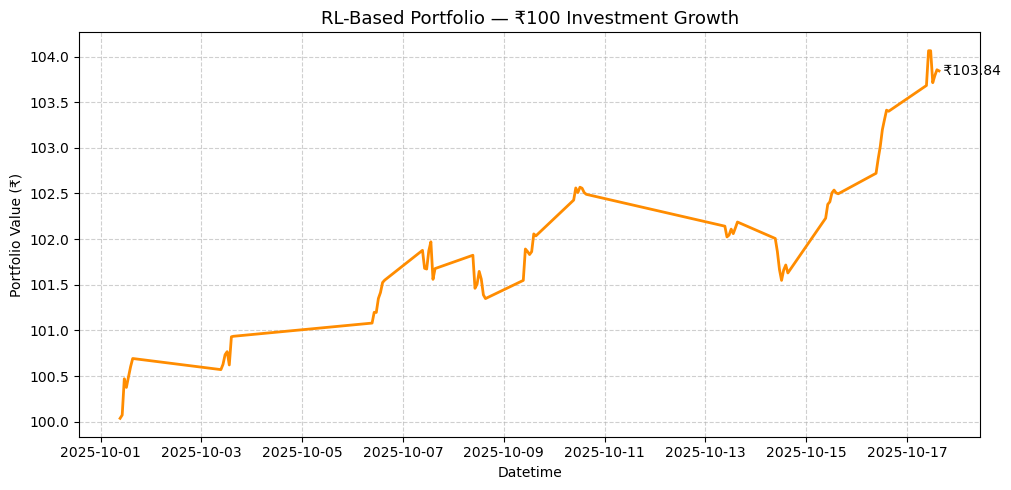

In [8]:
summary_rl, weights_rl, result_df = rl_portfolio_simulation(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    apply_date="2025-10-01",
    withdraw_date="2025-10-20",
    k=30,        # rolling window
    lr=0.05,    # learning rate
    gamma=0.9,  # discount factor
    episodes=100
)


In [9]:
result_df

,Datetime,Realized_Portfolio_Value
0,2025-10-01 09:15:00,100.036255
1,2025-10-01 10:15:00,100.072366
2,2025-10-01 11:15:00,100.469744
3,2025-10-01 12:15:00,100.375260
4,2025-10-01 13:15:00,100.491225
...,...,...
79,2025-10-17 11:15:00,104.063956
80,2025-10-17 12:15:00,103.713688
81,2025-10-17 13:15:00,103.791265
82,2025-10-17 14:15:00,103.855272
